In [3]:
from typing import Any, TypedDict

from langchain.chat_models import init_chat_model
from langchain_core.messages import AnyMessage
from langchain_core.messages.utils import count_tokens_approximately
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.checkpoint.memory import InMemorySaver

from dotenv import load_dotenv
import os
from langchain_google_genai import ChatGoogleGenerativeAI


load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_API_KEYYY")
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",google_api_key=  GEMINI_API_KEY )


In [ ]:
model.invoke("hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--bc7b02f5-69db-46a3-af53-ef414804bb02-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

: 

In [4]:


from typing import Annotated, Sequence
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, RemoveMessage
from langchain_openai import ChatOpenAI
import os


# Define our enhanced state with summary capability
class ConversationState(MessagesState):
    """Extended state that includes conversation summary"""
    summary: str = ""
    message_count: int = 0

# Configurationn
MAX_MESSAGES_BEFORE_SUMMARY = 6  # Summarize after every 6 messages
KEEP_RECENT_MESSAGES = 2  # Keep 2 most recent messages after summarization

def chatbot_node(state: ConversationState):
    """Main chatbot logic - responds to user messages"""
    # Get the conversation context
    messages = state["messages"]
    summary = state.get("summary", "")
    
    # If we have a summary, add it as context (but don't include in actual messages)
    context_messages = messages.copy()
    if summary:
        # Add summary as system context for better responses
        system_message = HumanMessage(
            content=f"[Previous conversation summary: {summary}]\n\nPlease respond naturally to the conversation, taking the summary into account for context."
        )
        context_messages = [system_message] + context_messages[-3:]  # Use last 3 messages + summary
    else:
        context_messages = state["messages"]
    
    # Generate response
    response = model.invoke(context_messages)
    
    return {
        "messages": [response],
        "message_count": state["message_count"] + 1
    }

def should_summarize(state: ConversationState) -> str:
    """Decide whether to summarize based on message count"""
    if state["message_count"] >= MAX_MESSAGES_BEFORE_SUMMARY:
        return "summarize"
    return "END"

def summarize_conversation(state: ConversationState):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is a summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}
    
    



In [5]:
    checkpointer= InMemorySaver()
    workflow = StateGraph(ConversationState)
    
    # Add nodes
    workflow.add_node("chatbot", chatbot_node)
    workflow.add_node("summarize", summarize_conversation)
    
    # Define the flow
    workflow.add_edge(START, "chatbot")
    workflow.add_conditional_edges(
        "chatbot",
        should_summarize,
        {
            "summarize": "summarize",
            "END": END
        }
    )
    workflow.add_edge("summarize",END)
    workflow.add_edge("chatbot",END) 

    app =workflow.compile(checkpointer=checkpointer)

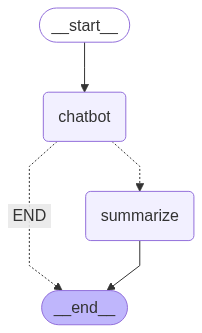

In [6]:
workflow.compile(checkpointer=checkpointer)

In [7]:
config = {"configurable": {"thread_id": 124}}
current_state = {       
        "messages": [HumanMessage(content="one line asswer who is uk")],
        "summary":"",
        "message_count":4
}
a =app.invoke(current_state,config=config)

a

{'messages': [HumanMessage(content='one line asswer who is uk', additional_kwargs={}, response_metadata={}, id='2268de83-8e95-43e1-9830-d4d741e3cc1f'),
  AIMessage(content='The United Kingdom is a sovereign country in Europe.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--33489e19-f1d6-4b4d-a8e7-feadb4915cdc-0', usage_metadata={'input_tokens': 7, 'output_tokens': 11, 'total_tokens': 18, 'input_token_details': {'cache_read': 0}})],
 'summary': '',
 'message_count': 5}

In [11]:
current_state = {       
        "messages": [HumanMessage(content="one line asswer who is paksitan")],
}
a =app.invoke(current_state,config=config)
a

{'messages': [HumanMessage(content='one line asswer who is paksitan', additional_kwargs={}, response_metadata={}, id='0d4e0322-9991-4852-9b8b-e9595de10757'),
  AIMessage(content='Pakistan is a country in South Asia.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--198ce481-9f94-4b09-a0a3-2759f0340cde-0', usage_metadata={'input_tokens': 85, 'output_tokens': 9, 'total_tokens': 94, 'input_token_details': {'cache_read': 0}})],
 'summary': 'The conversation began with a greeting, then moved to identifying the UK and Pakistan in single-line answers.',
 'message_count': 6}

In [13]:
len(a["messages"])

2